### NLP DE ARTICULOS DE LESIONES DE FUTBOLISTAS

In [200]:
!pip install requests beautifulsoup4 nltk spacy
!pip install requests beautifulsoup4 spacy
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 90.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [201]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import seaborn as sns
import string

Cargamos el modelo de procesamiento de lenguaje natural "es_core_news_sm" de spacy para entrenar con los articulos y noticias de lesiones en español, de modo que el modelo aprenda a diferenciar los artículos que hablan de ellas y los que no

In [202]:
nlp = spacy.load("es_core_news_sm")

urls_lesiones = [
    "https://www.newtral.es/lesiones-calendario-datos-preocupaciones-liga-masculina-futbol/20241117/",
    "https://www.heraldo.es/noticias/deportes/futbol/real-zaragoza/2025/02/11/la-plaga-de-lesiones-en-el-real-zaragoza-1798928.html",
    "https://www.relevo.com/futbol/liga-primera/lesion-rodrygo-tiempo-baja-20241023121800-nt.html",
    "https://www.france24.com/es/programas/lo-m%C3%A1s-destacado-de-2024/20250102-especial-deportes-futbol-lesiones-partidos",
    "https://www.sport.es/es/noticias/real-madrid/alarma-city-lesiones-clave-primera-114210232",
    "https://www.planetarealmadrid.com/curiosidades/cuantas-lesiones-ha-sufrido-real-madrid-esta-temporada-cifra-es-impactante_288826_102.html",
    "https://www.relevo.com/futbol/liga-primera/plaga-lesiones-preocupacion-sevilla-20250211112822-nt.html",
    "https://bolavip.com/laliga/real-madrid-encuentra-culpable-18-jugadores-se-han-lesionado-en-20-partidos",
    "https://www.jornadaperfecta.com/blog/lesionados-laliga-jornada-19-24-25/",
    "https://www.relevo.com/fantasy/sancionados-lesionados-jornada-laliga-sports-20240108200602-nt.html",
    "https://www.90min.com/es/chivas-de-guadalajara-lesionados-y-suspendidos-vs-leon-en-la-jornada-4-del-clausura-2025",
    "https://as.com/futbol/primera/fernando-pacheco-pasara-por-el-quirofano-n/",
    "https://as.com/futbol/primera/alaba-ni-copa-ni-derbi-ni-city-n/",
    "https://as.com/futbol/primera/la-lesion-de-galan-queda-en-un-esguince-n/",
    "https://as.com/futbol/champions/camavinga-tres-semanas-fuera-n/"
]

urls_no_lesiones = [
    "https://www.mundodeportivo.com/futbol/fc-barcelona/20250212/1002406371/dato-ilusionara-cules-emparejamiento-copa-atletico.html",
    "https://www.realbetisbalompie.es/noticias/actualidad/la-asignacion-de-entradas-para-los-partidos-a-domicilio-sera-por-sorteo-31048",
    "https://www.marca.com/futbol/real-madrid/2025/02/13/tema-vinicius-ritmo-marca-real-madrid.html",
    "https://www.fichajes.net/noticias/increible-fichaje-sergio-ramos-negocia-rayados-20250212.html",
    "https://www.prensalibre.com/deportes/futbol-internacional/champions-league-partidos-y-resultados-de-los-playoffs-de-ida-y-como-se-mantienen-las-llaves-a-octavos-breaking/",
    "https://www.marca.com/futbol/champions-league/2025/02/12/autores-pancarta-polemica-city-real-madrid-desvelan-aludia-vinicius.html",
    "https://as.com/futbol/primera/alineacion-posible-del-valencia-ante-el-leganes-en-laliga-ea-sports-n/",
    "https://www.laliga.com/noticias/laliga-desactiva-antes-del-derbi-de-madrid-la-plataforma-de-pirateria-de-vivo-duckvision",
    "https://www.infobae.com/america/agencias/2025/02/13/las-ligas-de-espana-y-japon-renuevan-su-colaboracion-para-fortalecer-el-futbol-femenino/",
    "https://www.lasexta.com/noticias/deportes/futbol/fuera-juego-flick-fallo-belgrado-asi-fue-gol-estrella-roja-barca_20241106672be65439a16c0001a40db7.html",
    "https://www.lasexta.com/noticias/deportes/futbol/habra-minuto-silencio-partidos-champions-europa-league-conference-victimas-dana_2024110467290d242914190001eb0802.html",
    "https://www.lasexta.com/noticias/deportes/futbol/sorteo-champions-league-nuevo-formato-fase-grupos-bolas-ordenador_2024082866cf0eb2797ae1000178349e.html"
]

def obtener_texto(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = " ".join([p.get_text() for p in paragraphs])
        return text
    else:
        return ""

articulos_lesiones = [obtener_texto(url) for url in urls_lesiones]

articulos_no_lesiones = [obtener_texto(url) for url in urls_no_lesiones]

etiquetas_lesiones = [1] * len(articulos_lesiones)
etiquetas_no_lesiones = [0] * len(articulos_no_lesiones)

articulos = articulos_lesiones + articulos_no_lesiones
etiquetas = etiquetas_lesiones + etiquetas_no_lesiones


Descargamos las stopwords en español de nltk para aplicarlo y lematizamos para que aprenda a escoger las palabras con raíces en común y las que no tienen que ver. Además convertimos todo a minúscula para procesar el texto mejor y ya con la propia función de lemmatizar también se tokeniza

In [203]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [204]:
def lematizar_y_filtrar(texto):
    texto = texto.lower()
    doc = nlp(texto)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words])

articulos_procesados = [lematizar_y_filtrar(articulo) for articulo in articulos]

articulos_procesados

['interesar tres rotura ligamento cruzado rodilla último jornada liga reavivar debate lesión calendario competición masculino fútbol estudio señalar lesión temporada anterior aunque real madrid liga champions reducir futbolista manifestar preocupación aumento partido año fifa incorporar mundial club final temporada lesión temporada índice lesión fútbol europeo masculino temporada señalar aumento aumentar lesión partido dato paralelo decir luis garijo responsable deporte profesional howden poder haber factor influir aunque evidencia año mundial lesionar jugar estudio señalar lesión aumentar año año temporada esperar trayectoria ascendente poner prueba profundidad plantilla garijo destacar contraste aumento continuado lesión premier league laliga bundesliga serie respecto club ligue francia reducir número equipo participant observir bajada media lesión equipo aunque solo temporada punto consideración relación número partido lesión lesión ligamento cruzado rodilla estudio universidad mála

Convertimos el texto a una matriz TF-IDF para asignarle un peso a cada palabra. Es decir, tener un parámetro de importancia de las palabras

In [205]:
vectorizer = TfidfVectorizer( tokenizer=word_tokenize, ngram_range=(1,2), max_df=0.95)
X_tfidf = vectorizer.fit_transform(articulos_procesados)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desarrollamos el modelo, para el que hemos usado una regresión logística y smote para equilibrar las clases (1 y 0, lesiones y futbol en general)

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, etiquetas, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=200)

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)

print("Mejor parámetro C:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Mejor parámetro C: {'C': 0.1}
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.80      0.80         5

    accuracy                           0.67         6
   macro avg       0.40      0.40      0.40         6
weighted avg       0.67      0.67      0.67         6



Tenemos que añadir más artículos para entrenarlo bien, pero también vamos a probar SVC como modelo, que parece que coge más artículos totales en 'support'

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, etiquetas, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

model = SVC(class_weight='balanced')

param_grid = {'C': [1, 5, 10, 50, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)

print(f"Mejor parámetro C: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_test)
print("Informe de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))


Mejor parámetro C: {'C': 5}
Informe de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      1.00      0.80         6

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [208]:
cv_scores = cross_val_score(grid_search.best_estimator_, X_tfidf, etiquetas, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Accuracy promedio en validación cruzada: {np.mean(cv_scores)}")

Cross-validation scores: [0.5 0.5 0.6 0.6 0.6]
Accuracy promedio en validación cruzada: 0.56


Añadimos más artículos que es lo que realmente está haciendo que nuestro modelo no aprenda tanto y bien


In [209]:
nlp = spacy.load("es_core_news_sm")

urls_lesiones = [
    "https://www.newtral.es/lesiones-calendario-datos-preocupaciones-liga-masculina-futbol/20241117/",
    "https://www.heraldo.es/noticias/deportes/futbol/real-zaragoza/2025/02/11/la-plaga-de-lesiones-en-el-real-zaragoza-1798928.html",
    "https://www.relevo.com/futbol/liga-primera/lesion-rodrygo-tiempo-baja-20241023121800-nt.html",
    "https://www.sport.es/es/noticias/real-madrid/alarma-city-lesiones-clave-primera-114210232",
    "https://www.planetarealmadrid.com/curiosidades/cuantas-lesiones-ha-sufrido-real-madrid-esta-temporada-cifra-es-impactante_288826_102.html",
    "https://www.relevo.com/futbol/liga-primera/plaga-lesiones-preocupacion-sevilla-20250211112822-nt.html",
    "https://bolavip.com/laliga/real-madrid-encuentra-culpable-18-jugadores-se-han-lesionado-en-20-partidos",
    "https://www.jornadaperfecta.com/blog/lesionados-laliga-jornada-19-24-25/",
    "https://www.relevo.com/fantasy/sancionados-lesionados-jornada-laliga-sports-20240108200602-nt.html",
    "https://www.90min.com/es/chivas-de-guadalajara-lesionados-y-suspendidos-vs-leon-en-la-jornada-4-del-clausura-2025",
    "https://as.com/futbol/primera/fernando-pacheco-pasara-por-el-quirofano-n/",
    "https://as.com/futbol/primera/alaba-ni-copa-ni-derbi-ni-city-n/",
    "https://as.com/futbol/primera/la-lesion-de-galan-queda-en-un-esguince-n/",
    "https://as.com/futbol/champions/camavinga-tres-semanas-fuera-n/",
    "https://www.mundodeportivo.com/futbol/premier-league/20250204/1002401096/calvario-tottenham-cesa-grave-lesion.html",
    "https://unanimodeportes.com/deportes/futbol/lesiones-jugadores-retiro/",
    "https://www.vozpopuli.com/deportes/lesiones-futbol-plantillas.html",
    "https://www.rtve.es/deportes/20241014/tres-meses-despues-luis-fuente-solo-puede-contar-con-cuatro-titulares-final-eurocopa/16286605.shtml",
    "https://as.com/futbol/segunda/iborra-de-lesion-en-lesion-n/",
    "https://as.com/futbol/internacional/umtiti-un-ano-sin-jugar-n/",
    "https://as.com/futbol/segunda/mourad-rashani-y-oscar-plano-bajas-contra-el-levante-n/",
    "https://www.marca.com/futbol/celta/2025/02/12/hugo-alvarez-estara-tres-semanas-baja.html",
    "https://www.marca.com/futbol/betis/2024/11/21/problemas-centro-campo-beris-fornals-seria-duda-valencia.html",
    "https://www.marca.com/futbol/alaves/2024/10/02/66fd3fcb22601d323d8b456f.html",
    "https://www.marca.com/bienestar/salud/2024/03/19/65f9d398e2704e470d8b457c.html"
]

urls_no_lesiones = [
    "https://www.mundodeportivo.com/futbol/fc-barcelona/20250212/1002406371/dato-ilusionara-cules-emparejamiento-copa-atletico.html",
    "https://www.realbetisbalompie.es/noticias/actualidad/la-asignacion-de-entradas-para-los-partidos-a-domicilio-sera-por-sorteo-31048",
    "https://www.marca.com/futbol/real-madrid/2025/02/13/tema-vinicius-ritmo-marca-real-madrid.html",
    "https://www.fichajes.net/noticias/increible-fichaje-sergio-ramos-negocia-rayados-20250212.html",
    "https://www.prensalibre.com/deportes/futbol-internacional/champions-league-partidos-y-resultados-de-los-playoffs-de-ida-y-como-se-mantienen-las-llaves-a-octavos-breaking/",
    "https://www.marca.com/futbol/champions-league/2025/02/12/autores-pancarta-polemica-city-real-madrid-desvelan-aludia-vinicius.html",
    "https://as.com/futbol/primera/alineacion-posible-del-valencia-ante-el-leganes-en-laliga-ea-sports-n/",
    "https://www.laliga.com/noticias/laliga-desactiva-antes-del-derbi-de-madrid-la-plataforma-de-pirateria-de-vivo-duckvision",
    "https://www.infobae.com/america/agencias/2025/02/13/las-ligas-de-espana-y-japon-renuevan-su-colaboracion-para-fortalecer-el-futbol-femenino/",
    "https://www.lasexta.com/noticias/deportes/futbol/fuera-juego-flick-fallo-belgrado-asi-fue-gol-estrella-roja-barca_20241106672be65439a16c0001a40db7.html",
    "https://www.lasexta.com/noticias/deportes/futbol/habra-minuto-silencio-partidos-champions-europa-league-conference-victimas-dana_2024110467290d242914190001eb0802.html",
    "https://www.lasexta.com/noticias/deportes/futbol/sorteo-champions-league-nuevo-formato-fase-grupos-bolas-ordenador_2024082866cf0eb2797ae1000178349e.html",
    "https://www.cmdsport.com/futbol/entrenamiento-futbol/el-aumento-de-sustituciones-en-los-partidos-de-futbol-mejora-el-rendimiento/",
    "https://www.eldiadecordoba.es/cordobacf/cordoba-cf-naming-arcangel-estrategia-clubes-futbol-profesional_0_2003294980.html",
    "https://xcatalunya.cat/es/deportes/fuera-futbol-italiano-estrategia-inedita-atalanta-ganar-barca",
    "https://www.infobae.com/espana/deportes/2024/07/31/futbol-femenino-la-bochornosa-estrategia-de-brasil-para-perder-tiempo-frente-a-espana-que-obligo-a-alargar-el-partido-16-minutos/",
    "https://www.mundodeportivo.com/futbol/premier-league/20241205/1002365962/arsenal-arteta-jover-rey-estrategia-premier.html",
    "https://www.marca.com/futbol/real-madrid/2025/02/13/ofrecio-vinicius.html",
    "https://www.marca.com/futbol/real-madrid/2025/02/13/regalo-esperaba-asencio.html",
    "https://www.marca.com/futbol/futbol-internacional/2025/02/13/espana-punto-superar-italia-quinto-equipo-champions.html",
    "https://www.marca.com/futbol/premier-league/2025/02/13/doble-vida-marc-guiu-pichichi-conference-inedito-premier.html",
    "https://www.mundodeportivo.com/futbol/fc-barcelona/20250213/1002406658/tah-elige-barca.html",
    "https://www.mundodeportivo.com/futbol/fc-barcelona/20250212/1002406618/pau-victor-9-partidos-entrando-ultimo-minuto.html",
    "https://www.mundodeportivo.com/futbol/fc-barcelona/20250213/1002406758/fallece-ex-vicepresidente-fc-barcelona-francesc-pulido.html",
    "https://www.mundodeportivo.com/futbol/fc-barcelona/20250213/1002406741/cubarsi-firma-hoy-renovacion.html"
]

def obtener_texto(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = " ".join([p.get_text() for p in paragraphs])
        return text
    else:
        return ""

articulos_lesiones = [obtener_texto(url) for url in urls_lesiones]

articulos_no_lesiones = [obtener_texto(url) for url in urls_no_lesiones]

etiquetas_lesiones = [1] * len(articulos_lesiones)
etiquetas_no_lesiones = [0] * len(articulos_no_lesiones)

articulos = articulos_lesiones + articulos_no_lesiones
etiquetas = etiquetas_lesiones + etiquetas_no_lesiones

In [210]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [211]:
def lematizar_y_filtrar(texto):
    texto = texto.lower()
    doc = nlp(texto)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words])

articulos_procesados = [lematizar_y_filtrar(articulo) for articulo in articulos]

In [212]:
vectorizer = TfidfVectorizer( tokenizer=word_tokenize, ngram_range=(1,2), max_df=0.95)
X_tfidf = vectorizer.fit_transform(articulos_procesados)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, etiquetas, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=200)

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)

print("Mejor parámetro C:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(grid_search.best_estimator_, X_tfidf, etiquetas, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Accuracy promedio en validación cruzada: {np.mean(cv_scores)}")

Mejor parámetro C: {'C': 100}
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10

Cross-validation scores: [0.8 0.7 0.9 0.9 0.9]
Accuracy promedio en validación cruzada: 0.8400000000000001


In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, etiquetas, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

model = SVC(class_weight='balanced')

param_grid = {'C': [1, 5, 10, 50, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)

print(f"Mejor parámetro C: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_test)
print("Informe de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))

Mejor parámetro C: {'C': 5}
Informe de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.71      0.71      0.71         7

    accuracy                           0.73        15
   macro avg       0.73      0.73      0.73        15
weighted avg       0.73      0.73      0.73        15



In [215]:
cv_scores = cross_val_score(grid_search.best_estimator_, X_tfidf, etiquetas, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Accuracy promedio en validación cruzada: {np.mean(cv_scores)}")

Cross-validation scores: [0.8 0.7 0.9 0.9 0.8]
Accuracy promedio en validación cruzada: 0.82


Este modelo también tiene un buen rendimiento, pero la validación cruzada le da un 82% de estabilidad. Menor a la regresión logísitca

In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

Vamos a valorar otros modelos

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, etiquetas, test_size=0.3, random_state=42)

models = {
    'SVC': SVC(C=10, kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

for name, model in models.items():
    print(f"\nEvaluando modelo {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nInforme de clasificación para {name}:")
    print(classification_report(y_test, y_pred))

    cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Accuracy promedio en validación cruzada para {name}: {cross_val.mean()}")



Evaluando modelo SVC...

Informe de clasificación para SVC:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.71      0.71      0.71         7

    accuracy                           0.73        15
   macro avg       0.73      0.73      0.73        15
weighted avg       0.73      0.73      0.73        15

Accuracy promedio en validación cruzada para SVC: 0.9428571428571428

Evaluando modelo Random Forest...

Informe de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.62      0.71      0.67         7

    accuracy                           0.67        15
   macro avg       0.67      0.67      0.67        15
weighted avg       0.67      0.67      0.67        15

Accuracy promedio en validación cruzada para Random Forest: 0.6571428571428571

Evaluando modelo Decision Tree...

Informe de clasifica

Podemos concluir que SVC es buen modelo en general, pero gracias a la validación cruzada, con 94% de accuracy. Generaliza bien, aunque es cierto que tiene métricas algo peores en precisión y recall otros modelos.
La regresión logísitca tiene un buen rendimiento también, con buen accuracy y métricas de precisión y recall. El peor rendimiento con validación cruzada lo tiene el Random Forest, que incluso puede que esté sobreajustando

 Lo que más nos interesa ahora mismo es que sea un modelo que detecte como lesión lo que realmente es una lesión, por lo que necesitamos una alta precisión en la clase 1 (artículos de lesiones), por lo que el random forest podríamos investigarlo a ver qué tal. Si queremos un equilibrio, podríamos optar por la Regresión Logística, que tiene un f1-score de 0.86 y además nos ayuda a detectar la mayor cantidad de artículos sobre lesiones, con un recall perfecto de la clase 1.

Como la Regresion Logistica ya la teníamos anteriormente seleccionada como best_model, vamos a comporbar qué tal es para el conjunto de prueba, ver su curva de aprendizaje y graficar la matriz de confusión


In [218]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_model.predict(X_test)

print("Informe de clasificación para el conjunto de prueba:")
print(classification_report(y_test, y_pred))

print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))


Informe de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.88      1.00      0.93         7

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15

Precisión en el conjunto de prueba: 0.9333333333333333


Nos da unos datos bastante buenos y una curva de aprendizaje bastante aceptable. Se observa como necesitabamos más artículos para procesar al principio, ya que no aprendía e incluso bajaba la precisión. A partir de los 9 artículos tienen un crecimiento constante y se va estabilizando un poco a partir de 21 artículos de fútbol

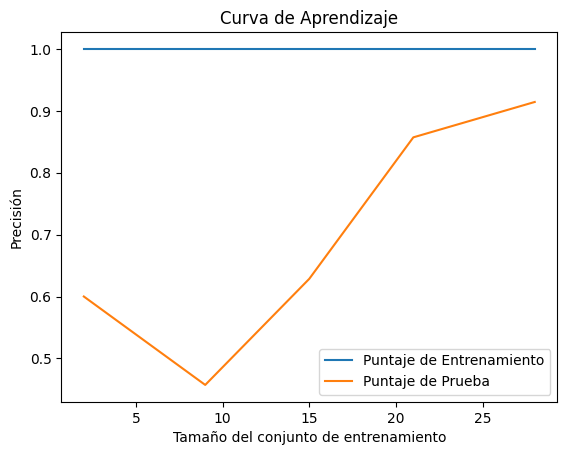

In [219]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Puntaje de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, label="Puntaje de Prueba")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.show()


En la matriz de confusión observamos que las predicciones de fútbol general son perfectas con los datos que tenemos y que solo ha fallado en una predicción de lesión que realmente era fútbol en general

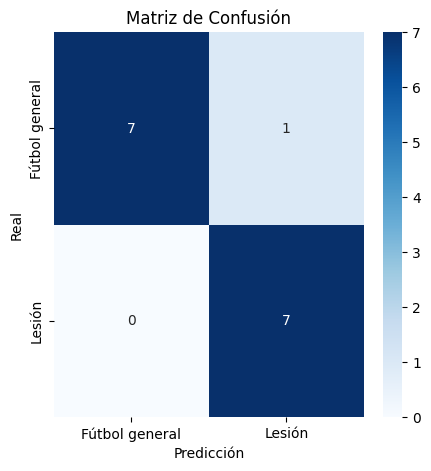

In [220]:
from sklearn.metrics import confusion_matrix

cm_logisticregression = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm_logisticregression, annot=True, fmt='d', cmap='Blues', xticklabels=['Fútbol general', 'Lesión'], yticklabels=['Fútbol general', 'Lesión'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Para Random Forest

In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_res, y_train_res)

best_model = grid_search_rf.best_estimator_

y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [222]:
y_pred = best_model.predict(X_test)

print("Informe de clasificación para el conjunto de prueba:")
print(classification_report(y_test, y_pred))

print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

Informe de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.83      0.71      0.77         7

    accuracy                           0.80        15
   macro avg       0.81      0.79      0.80        15
weighted avg       0.80      0.80      0.80        15

Precisión en el conjunto de prueba: 0.8


La curva de aprendizaje del Random Forest también muestra que va mejorando la predicción según le damos más artículos para analizar. Aún así, RF no llega a la precisión que nos da la regresión logísitica

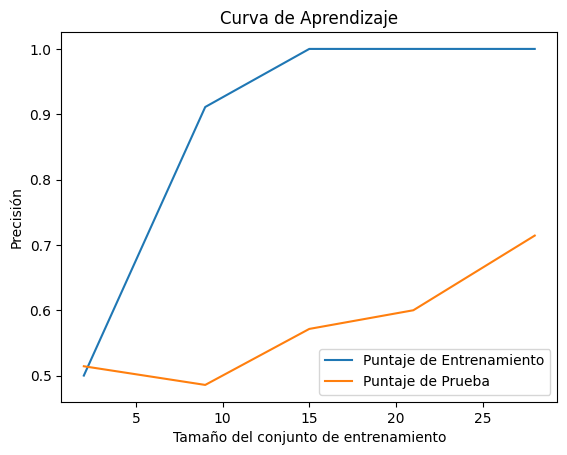

In [223]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Puntaje de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, label="Puntaje de Prueba")
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.show()

Con la matriz de confusión vemos como el Random Forest no predice tan bien, a pesar de tener buenas métricas ne la evaluación. Aquí, al revés que la regresión, falla 2 artículos que son de lesiones y cataloga como fútbol en general y otros dos a la inversa (predice lesión y son futbol en general

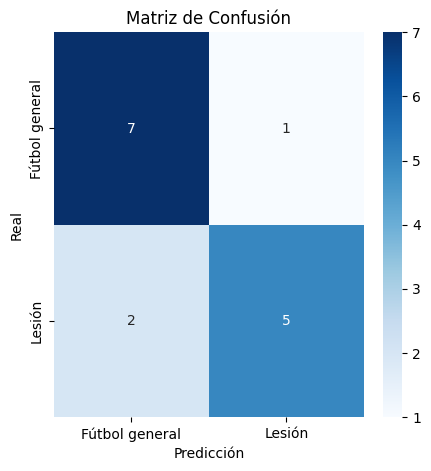

In [224]:
cm_rf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Fútbol general', 'Lesión'], yticklabels=['Fútbol general', 'Lesión'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Ahora que también hemos visualizando vemos que el modelo de Regresión Logística es mejor, en acierto, predicción y en precisión en conjunto de prueba que da un 93% de precisión. Random Forest tiene mucha menos precisión en prueba y además falla al clasificar varios artículos. Así que nos quedamos y procedemos a guardar la Regresión Logística, ya que lo que más nos importa son los artículos de lesiones y la precisión en test.

 Finalmente, el SVC no da tan buenos resultados tampoco, por lo que lo hemos desechado.

In [225]:
import joblib

best_model = grid_search.best_estimator_

joblib.dump(best_model, 'modelo_lesiones_LR.pkl')



['modelo_lesiones_LR.pkl']

____

### MODELO DE DEEP LEARNING CON BERT Y HUGGING FACE

In [226]:
!pip install transformers datasets torch

In [227]:
from huggingface_hub import login
from datasets import Dataset
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

In [228]:
login()

Recuperamos los datos de los artículos que ya teníamos, donde ya los teníamos etiquetados entre lesión y fútbol en general. Con ello creamos el dataset para dividir los datos para hacer train y test (entrenamiento y prueba)

In [229]:
data = {
    "text": articulos,
    "label": etiquetas
}

dataset = Dataset.from_dict(data)

train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

Cargamos el tokenizador de BERT y el propio modelo BERT, para preentrenarlo en español. Despue´s creamos la función para hacer la tokenización y aplicarlo al dataset de train y test

In [230]:
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [231]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creamos la función para calcular la precisión del modelo y utilizamos los argumentos de entrenamiento, donde ya introducimos esa métrica de precisión (accuracy):

In [232]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [233]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Ahora hacemos el trainer con el modelo y entrenamos el modelo completo

In [234]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [235]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.738045,0.300000
2,No log,0.471115,0.800000
3,No log,0.420039,0.900000


TrainOutput(global_step=15, training_loss=0.5398579915364583, metrics={'train_runtime': 56.5285, 'train_samples_per_second': 2.123, 'train_steps_per_second': 0.265, 'total_flos': 31573326643200.0, 'train_loss': 0.5398579915364583, 'epoch': 3.0})

In [236]:
eval_results = trainer.evaluate()
eval_results


{'eval_loss': 0.42003852128982544,
 'eval_accuracy': 0.9,
 'eval_runtime': 0.3802,
 'eval_samples_per_second': 26.303,
 'eval_steps_per_second': 5.261,
 'epoch': 3.0}

Guardamos el modelo y comprobamos que funcione con texto:

In [237]:
model.save_pretrained("./modelo_lesiones_bert")
tokenizer.save_pretrained("./modelo_lesiones_bert")

('./modelo_lesiones_bert/tokenizer_config.json',
 './modelo_lesiones_bert/special_tokens_map.json',
 './modelo_lesiones_bert/vocab.txt',
 './modelo_lesiones_bert/added_tokens.json')

In [238]:
model = BertForSequenceClassification.from_pretrained("./modelo_lesiones_bert")
tokenizer = BertTokenizer.from_pretrained("./modelo_lesiones_bert")

def predecir(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = logits.argmax(axis=-1).item()
    return "Lesión" if prediction == 1 else "Fútbol en general"

nuevo_articulo = "Koke sufre una lesión muscular en la pierna derecha. Nuestro capitán acabó el encuentro ante el RC Celta con molestias y se ha sometido a pruebas médicas que han confirmado el alcance de la lesión. Koke acabó el partido del pasado sábado ante el RC Celta con molestias. El centrocampista se ha sometido a pruebas y el parte ofrecido por los servicios médicos del club indica que nuestro capitán sufre una lesión muscular en la pierna derecha. El centrocampista rojiblanco realizará sesiones de fisioterapia y trabajo de readaptación en el gimnasio y la evolución de su lesión determinará su regreso a la competición. "
resultado = predecir(nuevo_articulo)
print(f"El artículo pertenece a: {resultado}")

El artículo pertenece a: Lesión


In [239]:
model = BertForSequenceClassification.from_pretrained("./modelo_lesiones_bert")
tokenizer = BertTokenizer.from_pretrained("./modelo_lesiones_bert")

def predecir(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = logits.argmax(axis=-1).item()
    return "Lesión" if prediction == 1 else "Fútbol en general"

nuevo_articulo = "Y los cuatro protectores de Courtois, los perfilados más Asencio y Mendy. Es decir, Valverde como lateral derecho, una vez más (la séptima en la temporada) y Rüdiger, tras superar su lesión en el bíceps femoral, directo al once. A una noche de las que ponen de punta los pelos al alemán. Un reto, tener a Haaland enfrente, que dispara aún una motivación que su fútbol lleva intrínseco. Además, contará con Asencio tras su bautismo del Etihad y un Mendy que, en la batalla perenne con Fran García, está ante un examen importante. De modo que el once que le sobrevuela la mente a Ancelotti es el siguiente: Courtois; Valverde, Asencio, Rüdiger, Mendy; Tchouameni, Ceballos; Rodrygo, Bellingham, Vinicius; y Mbappé."
resultado = predecir(nuevo_articulo)
print(f"El artículo pertenece a: {resultado}")

El artículo pertenece a: Lesión
